In [4]:
import tensorflow as tf
print("num of GPUs:", len(tf.config.experimental.list_physical_devices('GPU'))) #importing the number of available CPUs

num of GPUs: 0


In [5]:
#import libraries
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import splitfolders
#import shutil
from keras import initializers
import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#import pydot
from IPython import get_ipython
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
#%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
import os
import glob
import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN
import keras_video
from keras_video import utils as ku


In [6]:
#splitfolders.ratio('/Users/tamima_rashid/Desktop/Data/IRB/IRB_CNN/IRB_Ori+Aug/', output="/Users/tamima_rashid/Desktop/Data/IRB/IRB_CNN/IRB_Ori+Aug/", seed=1337, ratio=(.75,.15,.10))



In [16]:
#Reading the class names from the directory
from keras_video import VideoFrameGenerator
# use sub directories names as classes
classes = [i.split(os.path.sep)[8] for i in glob.glob('/Users/tamima_rashid/Desktop/Data/Data_RNN/Gemep+IRB/train/*')]
classes

['Happy', 'Sad', 'Fear', 'Surprise', 'Anger', 'Disgust']

In [7]:
# In[9]:

#training videos directories for each class
glob_pattern_train='/Users/tamima_rashid/Desktop/Data/Data_RNN/Gemep+IRB/train/{classname}/*.avi'


# In[10]:


# assigning global parameters
SIZE = (112, 112) #resizing 720*576 size videos to 112*112 for input
CHANNELS = 3
NBFRAME = 20 # 20 frames for each sequence.
BS = 18 #batch_size


# In[11]:


# for data augmentation, data augmentation is randomly 
#seed assigned so that same randomness is applied everytime applied
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1, #zooming the video by 10%
    horizontal_flip=True, #because I have left side and right side views
    rotation_range=8, # rotate the video randomly by 8 degree so that the classification can support a different angle
    width_shift_range=.2, #All the subjects are in the center, width_shift shifts the frames along x-axis by 20%
    height_shift_range=.2) #All the subjects are in the center, width_shift shifts the frames along y-axis by 20%


# In[12]:


# Create video frame generator
train = keras_video.SlidingFrameGenerator(
    classes=classes, #classnames from directories for each class
    glob_pattern=glob_pattern_train, #Reading training files from directory
    nb_frames=NBFRAME, #20 frames for each sequence, making 6 sequences from each videos
    shuffle=True, #shuffling training data to reduce bias and overfitting as the datasets are sorted by class
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,#Applying data_augmentation to create real world like variations for training 
    seed = 1337,#Same randomness is applied each time for training
    use_frame_cache=False) #Saves memory, if set true saves the sequences in memory after 1st epoch and read from the memory after that

Total data: 6 classes for 528 files for train
Checking files to find possible sequences, please wait...
For 528 files, I found 11088 possible sequence samples


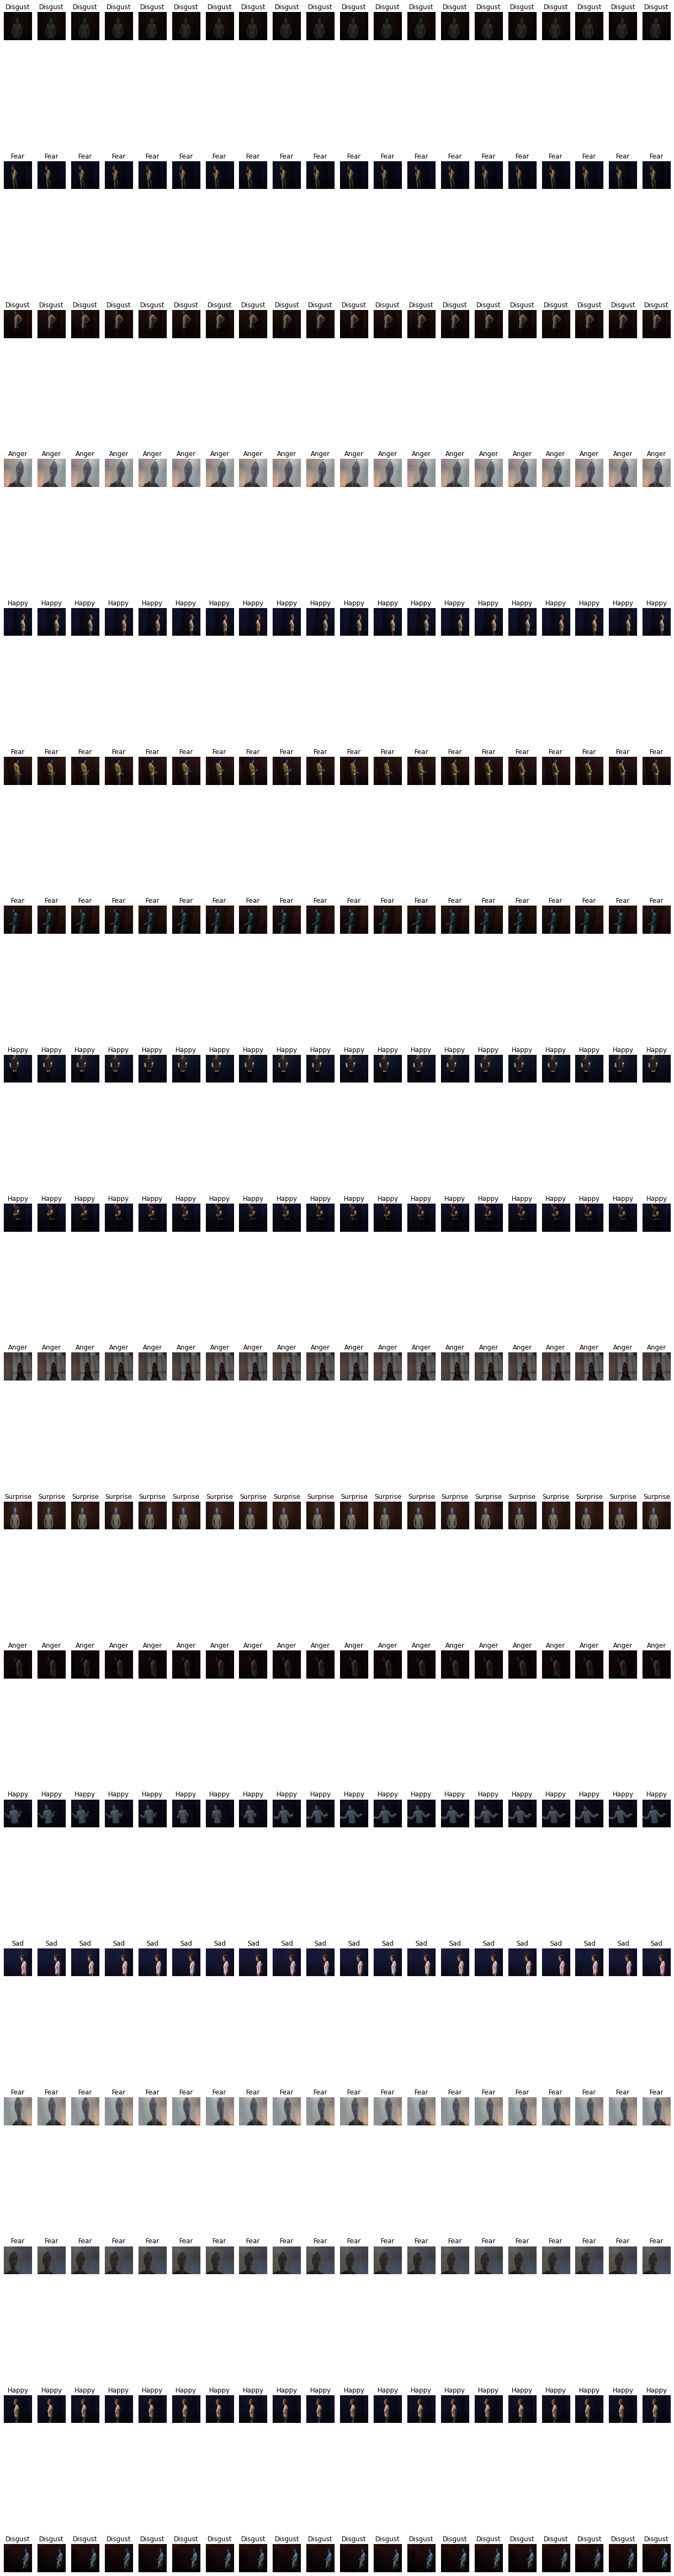

In [8]:
ku.show_sample(train, random=False)

In [9]:
# In[13]:

#validation videos directories for each class
glob_pattern_val='/Users/tamima_rashid/Desktop/Data/Data_RNN/Gemep+IRB/val/{classname}/*.avi'

valid = keras_video.SlidingFrameGenerator(
    classes=classes, #classnames from directories for each class
    glob_pattern=glob_pattern_val,#Reading validation files from directory
    nb_frames=NBFRAME,
    shuffle=False, #validation set is used to measure the performance while the model is being trained, so it is not necessary to shuffle validation_data
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=False)

Total data: 6 classes for 66 files for train
Checking files to find possible sequences, please wait...
For 66 files, I found 1386 possible sequence samples


In [10]:
#test videos directories for each class
glob_pattern_test='/Users/tamima_rashid/Desktop/Data/Data_RNN/Gemep+IRB/test/{classname}/*.avi'
test = keras_video.SlidingFrameGenerator(
    classes=classes, #classnames from directories for each class
    glob_pattern=glob_pattern_test,#Reading testing files from directory
    nb_frames=NBFRAME,
    shuffle=False, #validation set is used to measure the performance while the model is being trained, so it is not necessary to shuffle test_data
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=False)

Total data: 6 classes for 66 files for train
Checking files to find possible sequences, please wait...
For 66 files, I found 1386 possible sequence samples


In [11]:
# In[14]:

#Function for convolution layer for features extraction from each frame in the sequences
from keras.layers import Conv2D, BatchNormalization, AvgPool2D, MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(112, 112, 3)): #shape=size*channel
    momentum = .9
    model = keras.Sequential()
    model.add(BatchNormalization(input_shape=shape)) #BN to standardize inputs 
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu', use_bias=False)) # layer output shape- 112*112*64
    model.add(MaxPooling2D(pool_size=(2, 2))) #layer output shape- 56*56*64
    model.add(Conv2D(128, (5, 5), activation='relu', use_bias=False)) #layer output shape- 52*52*128=((s-f)/st)+1
    model.add(MaxPooling2D(pool_size=(2, 2))) #layer output shape- 26*26*128
    model.add(Conv2D(256, (5, 5), activation='relu', use_bias=False))#layer output shape- 22*22*256
    model.add(AvgPool2D(pool_size=(11, 11), strides=11))#layer output shape- 2*2*256
    model.add(Flatten()) #1024 features for each frame
    return model

In [12]:
# In[15]:


from keras.layers import TimeDistributed, Dense, Dropout
def action_model(shape=(20, 112, 112, 3), nbout=6): #20 images are going to time distributed layer at a time as sequence
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:]) 
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (20, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    #using 20 RNN units as I am using 20 frames per sequence,
    model.add(SimpleRNN(20)) #activation= tanh, kernel_initializer = glorot_uniform, return_sequence= false, 
    model.add(Dropout(.5))
    model.add(Dense(100, activation='relu')) 
    model.add(Dropout(.5))
    model.add(Dense(nbout, activation='softmax')) #nbout= number of classes
    return model


# In[18]:

In [13]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (20, 112, 112, 3)
INSHAPE

(20, 112, 112, 3)

In [14]:
model = action_model(INSHAPE, 6)# 6 means number of classes
optimizer = keras.optimizers.SGD(lr=.01, decay=1e-5, momentum=.9)
model.compile(
    optimizer,
    loss ='mean_squared_error',
    metrics=['acc']
)

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 1024)          1028812   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 20)                20900     
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               2100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 1,052,418
Trainable params: 1,052,412
Non-trainable params: 6
____________________________________________

In [ ]:
# In[19]:

#assigning epochs and start training
EPOCHS=100
start = time.time()
history = model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS)
stop = time.time()
print(f"Training time: {stop - start}s")

In [17]:
x_test, y_test = test.next() #separating the X values and y values from the test set

In [ ]:
# In[21]:
#
train_results = model.evaluate(train, verbose = 2)
test_results = model.evaluate(test, verbose = 2)

In [ ]:
#making lists for y_true_test values and y_predicted_test values
y_test = []
y_predict = []
for x in range(test.__len__()):
    batch = test.__getitem__(x)[1] #getting the labels of the sequence from the test set
    batch_predicted = model.predict(test.__getitem__(x)[0]) #prediciting the class of the sequence from the test set

    for y in range(BS):
        y_test.append(batch[y]) #appending the label values in y_test
        y_predict.append(batch_predicted[0]) ##appending the label values in batch_predicted

In [ ]:
# In[23]:
#returning the index of the higest value by column i.e for [0,0,1,0,0,0] it returns 2 which means class= "Fear"
y_test_class = np.argmax(y_test, axis=1)
y_predict_class = np.argmax(y_predict, axis=1)
# In[26]:

In [ ]:
#generating classification reporrt
from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_predict_class, target_names=["Anger", "Disgust", "Fear", "Happy", "Sad", "Surprise"] ))

In [ ]:
# In[27]:

history_dict = history.history
print(history_dict.keys())
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# In[28]:

#generatingg training accuracy vs validation accuracy 
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('accuracy curve_RNN_six_emos.png')
plt.figure()

#generatingg training loss vs validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss.png')
plt.legend()
#plt.savefig('loss curve_RNN_six_emos')
plt.show()

In [ ]:
# In[29]:

#generating confusion matrix
target_names = [] 
for key in classes: 
    target_names.append(key) 
    
print(target_names)


# In[30]:


from sklearn.metrics import classification_report, confusion_matrix 
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues): 
    """ 
    This function prints and plots the confusion matrix. 
    Normalization can be applied by setting `normalize=True`. 
    """ 
    #plt.figure(figsize=(8,8))

    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title) 
    #plt.colorbar()

    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes) 
    plt.yticks(tick_marks, classes)

    if normalize: 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
        cm = np.around(cm, decimals=2) 
        cm[np.isnan(cm)] = 0.0 
        print("Normalized confusion matrix") 
    else: 
        print('Confusion matrix, without normalization') 
    thresh = cm.max() / 2. 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): 
        plt.text(j, i, cm[i, j], 
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black") 
    #plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 
  

#thresh = cm.max() / 2. 
#Matplotlib’s matshow 
cm = confusion_matrix(y_test_class, y_predict_class)

plt.figure(3) 
plot_confusion_matrix(cm, target_names, title='Confusion matrix') 
#print(cm) 
#plt.savefig('confusion_matrix_RNN_six_emos.png') 
plt.show()


# In[ ]:

In [ ]:
sto = time.time()
print(f"Total time: {sto-st}s")